* [I. Introduction](#I)
    * [1.1 Generate standard HOSE Codes](#1.1)
    * [1.2 Generate Stereo-Enhanced HOSE Codes](#1.2)
* [II. HOSE-Based Nearest Neighbors Model](#II)
    * [2.1 Database Creation](#2.1)
    * [2.2 Prediction on the Validation dataset](#2.2)
        * [2.2.1. Generate HOSE codes for the Validation dataset](#2.2.1)
        * [2.2.2 Search the database and get prediction results](#2.2.2)
        * [2.2.3 Visualize Prediction Performance in the Validation Dataset](#2.2.3)
* [III. Compare prediction results using different model](#III)

# I. Introduction<a class="anchor" id="I"></a>
## 1.1 Generate standard HOSE Codes<a class="anchor" id="1.2"></a>
The HOSE code is hierarchical descriptors that encode information about the chemical environment around an atom.  It is built sphere-wise around the atom described;

In [1]:
# !pip install -e .
import sys
import os
import pandas as pd
from rdkit import Chem

RANDOM_STATE = 1

from sklearn.model_selection import train_test_split

# plot
import matplotlib.pyplot as plt

%matplotlib inline

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    hose_code,
)  # Some common methods I defined


from hosegen import HoseGenerator
from hosegen.geometry import *

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

The methods *get_Hose_codes* and *get_Hose_codes_from_file* can be used to generate a standard HOSE code.
Both need the index of the atom for which the HOSE code should be created as *atom_idx*. *max_radius* gives the number of spheres to use (default 5). *usestereo*, *wedgebond*, and *strict* are only used for the stereo-enhanced hose code (see below).

In [2]:
compound = Chem.MolFromSmiles("FC(F)=C(F)Oc1ccc(CBr)cc1")
gen = HoseGenerator()
gen.get_Hose_codes(compound, 0)

'F-1;C(=CF/OF,/C,)*C*C/'

## 1.2 Generate Stereo-Enhanced HOSE Codes<a class="anchor" id="1.3"></a>
HOSE codes are generated for a specified atom in the molecule, considering stereochemistry and different neighborhood radii around that atom.

In [3]:
# Input SMILES with double bond
smiles_input = "FC(F)=C(F)Oc1ccc(CBr)cc1"

# Create a molecule object from the SMILES string
mol = Chem.MolFromSmiles(smiles_input)

# Generate the canonical SMILES while preserving stereochemistry
canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)

output_file_path = "Example.mol"
Chem.MolToMolFile(mol, output_file_path)

# A map of wedge bonds. Wedge bonds in chemistry are used to represent the 3D orientation of bonds
wedgemap = create_wedgemap(output_file_path)

# Initializes an instance of the HoseGenerator class
gen = HoseGenerator()

# Generate HOSE codes for atom 0 in the molecule
gen.get_Hose_codes(mol, 0, usestereo=True, max_radius=6, wedgebond=wedgemap)

'F-1;C(=CF/OF,/C,)*C*C/*C,*C/'

# II. HOSE-Based Nearest Neighbors Model<a class="anchor" id="II"></a>

The **HOSE-Based Nearest Neighbors Model** relies entirely on a database-driven search using HOSE codes. This approach demonstrates strong predictive performance when the training data contains highly similar molecules.

**Methodology:**

1. **Database Creation**: A HOSE Code-NMR shift database is constructed from the training dataset.
2. **Prediction**: For each atom in the validation/test dataset, the database is searched to find atoms with the same HOSE code. If multiple matches are found, the predicted shift is the average of their shifts.

HOSE codes can be generated with different radii. For a new atom, the search starts by looking for an exact match in the database with HOSE code generated with maximum radius (`max_radius`) of 6. If multiple matches are found, the average shift is returned and assigned a `similarity score` of 6. If no match is found, the search proceeds with HOSE code generated with `max_radius = 5`, and so on, until a match is found.

**Similarity Scoring:**

The similarity score for each prediction, which reflects the accuracy of the prediction to some extent, is based on the radius level of the HOSE code where a match is found
- **6**: Match found with `max_radius = 6`
- **5**: Match found with `max_radius = 5`
- **4**: Match found with `max_radius = 4` (HOSE codes with four or more spheres, including stereochemistry, are considered reliable)
- **3**: Match found with `max_radius = 3`
- **2**: Match found with `max_radius = 2`
- **1**: Match found with `max_radius = 1`



## 2.1 Database Creation<a class="anchor" id="2.1"></a>
A HOSE Code-NMR shift database is constructed from the training dataset.

In [4]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

all_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

# Train, validation, test dataset split
train_fluorinated_compounds, test_fluorinated_compounds = train_test_split(
    all_fluorinated_compounds, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
train_fluorinated_compounds, vali_fluorinated_compounds = train_test_split(
    train_fluorinated_compounds, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
print(
    f"Number of fluorinated_compounds in the train dataset: {train_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the validation dataset: {vali_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the test dataset: {test_fluorinated_compounds.shape[0]}"
)

Number of fluorinated_compounds in the train dataset: 439
Number of fluorinated_compounds in the validation dataset: 110
Number of fluorinated_compounds in the test dataset: 98


In [5]:
example = all_fluorinated_compounds[
    all_fluorinated_compounds["Compound name"] == "perfluoropropionic acid"
]
example = hose_code.getHoseCodeContent(example)
example

,0,1,2,3,4,5,NMR_Peaks
4_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
5_COOH_1,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/=OO,FFF,/)","F-1;C(CCF/=OO,FFF,/,,,,)","F-1;C(CCF/=OO,FFF,/,,,,)/","F-1;C(CCF/=OO,FFF,/,,,,)//",-122.45
7_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4
8_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4
9_COOH_1,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/CFF,,/)","F-1;C(CFF/CFF,,/=OO,,)","F-1;C(CFF/CFF,,/=OO,,),/","F-1;C(CFF/CFF,,/=OO,,),//",-83.4


In [6]:
HOSE_Code_database = hose_code.getHoseCodeContent(train_fluorinated_compounds)
print(f"Shape of the training dataset: {HOSE_Code_database.shape}")
HOSE_Code_database.head(3)

Shape of the training dataset: (2351, 7)


,0,1,2,3,4,5,NMR_Peaks
4_ether_12,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/CFF,=OO,/)","F-1;C(CCF/CFF,=OO,/OFF,,,,)","F-1;C(CCF/CFF,=OO,/OFF,,,,)C,,/","F-1;C(CCF/CFF,=OO,/OFF,,,,)C,,/FFF/",-119.9
5_ether_12,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/CFF,=OO,/)","F-1;C(CCF/CFF,=OO,/OFF,,,,)","F-1;C(CCF/CFF,=OO,/OFF,,,,)C,,/","F-1;C(CCF/CFF,=OO,/OFF,,,,)C,,/FFF/",-119.9
7_ether_12,F-1;C(//),F-1;C(CCF//),"F-1;C(CCF/CFF,OFF,/)","F-1;C(CCF/CFF,OFF,/=OO,,,C,,)","F-1;C(CCF/CFF,OFF,/=OO,,,C,,),,FFF/","F-1;C(CCF/CFF,OFF,/=OO,,,C,,),,FFF/,,/",-129.4


In [7]:
# Save the database to a csv file
file_path = os.path.join(
    "..", "artifacts", "temp", "HOSE_Code_database_from_train_dataset.csv"
)
HOSE_Code_database.to_csv(file_path, encoding="utf-8")

# Transform column names to int where possible
HOSE_Code_database.columns = [
    common.convert_column_name(name) for name in HOSE_Code_database.columns
]

## 2.2 Prediction on the Validation dataset<a class="anchor" id="2.2"></a>
## 2.2.1. Generate HOSE codes for the Validation dataset<a class="anchor" id="2.2.1"></a>

In [8]:
HOSE_codes_vali = hose_code.getHoseCodeContent(vali_fluorinated_compounds)
print(f"Shape of the validation dataset: {HOSE_codes_vali.shape}")
HOSE_codes_vali.head(3)

Shape of the validation dataset: (658, 7)


,0,1,2,3,4,5,NMR_Peaks
4_From_Review_316,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/C,,/)","F-1;C(CFF/C,,/N)","F-1;C(CFF/C,,/N)/","F-1;C(CFF/C,,/N)//",-66.0
5_From_Review_316,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/C,,/)","F-1;C(CFF/C,,/N)","F-1;C(CFF/C,,/N)/","F-1;C(CFF/C,,/N)//",-66.0
6_From_Review_316,F-1;C(//),F-1;C(CFF//),"F-1;C(CFF/C,,/)","F-1;C(CFF/C,,/N)","F-1;C(CFF/C,,/N)/","F-1;C(CFF/C,,/N)//",-66.0


## 2.2.2 Search the database and get prediction results<a class="anchor" id="2.2.2"></a>

In [9]:
# Get HOSE Code and corresponding 19F NMR values using train dataset
sphere_dics = hose_code.getTrainDictionary_HOSE(HOSE_Code_database)

HOSE_Code_database["NMR_Peaks"] = HOSE_Code_database["NMR_Peaks"].astype(float)

# Get prediction results and corresponding similarity levels for the validation dataset
prediction, similarity_levels = hose_code.HOSE_Model(
    sphere_dics, HOSE_codes_vali, HOSE_Code_database["NMR_Peaks"].mean()
)

# Validation dataset
results = hose_code.getResults_HOSE(prediction, similarity_levels, HOSE_codes_vali)
results.head(4)

,actual,prediction,diff,similarity_levels
4_From_Review_316,-66.00,-65.585714,0.414286,3
5_From_Review_316,-66.00,-65.585714,0.414286,3
6_From_Review_316,-66.00,-65.585714,0.414286,3
7_SO3H_25,-115.13,-114.380000,0.750000,6


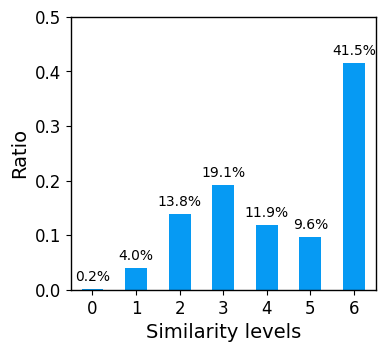

In [10]:
# Plot the distribution of data points across different similarity levels
# Sort the value counts by the index (the similarity levels)
sorted_counts = results["similarity_levels"].value_counts(normalize=True).sort_index()

cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

# Plotting the sorted value counts
ax = sorted_counts.plot(kind="bar", color="#069AF3")

# Adding the percentage labels above each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1%}",  # Format the height as a percentage
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # Position for the annotation
        ha="center",  # Horizontal alignment: center
        va="center",  # Vertical alignment: center
        xytext=(0, 9),  # Offset the text by 9 points above the bar
        textcoords="offset points",  # Use offset points to position the text
    )

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Similarity levels", fontsize=14)  # Replace with your label
ax.set_ylabel("Ratio", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

ax.set_ylim([0, 0.5])
# Set the x-axis labels in the correct order
ax.set_xticklabels(sorted_counts.index)
ax.tick_params(axis="x", rotation=0)

plt.show()

The distribution of data points in the validation dataset across different similarity levels

## 2.2.3 Visualize Prediction Performance in the Validation Dataset<a class="anchor" id="2.2.3"></a>

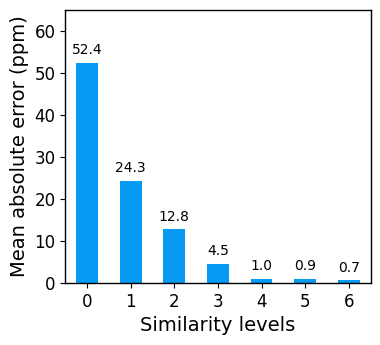

In [11]:
# Create the figure and axes with specified size
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm
ax = (
    results.groupby("similarity_levels")["diff"]
    .mean()
    .plot(kind="bar", color="#069AF3")
)

# Add the height (mean value) above each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}",  # Format the height to two decimal places
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # Position for the annotation
        ha="center",  # Horizontal alignment: center
        va="center",  # Vertical alignment: center
        xytext=(0, 9),  # Offset the text by 9 points above the bar
        textcoords="offset points",  # Use offset points to position the text
    )

ax.tick_params(axis="x", rotation=0)

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Similarity levels", fontsize=14)  # Replace with your label
ax.set_ylabel("Mean absolute error (ppm)", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

ax.set_ylim([0, 65])

plt.show()

Prediction performance of the HOSE-Based Nearest Neighbors Model on the validation dataset

In [12]:
file_path = os.path.join(
    "..", "artifacts", "results", "results_validation_dataset_HOSE_based model.csv"
)
results.to_csv(file_path, encoding="utf-8")

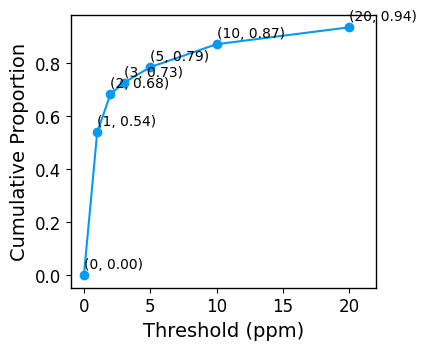

In [13]:
common.plot_prediction_performance(results, figure_title=None)

Cumulative Distribution of Prediction Error on the Validation Dataset


R2 = 0.90
RMSE = 9.09
MAE = 4.127073235810123


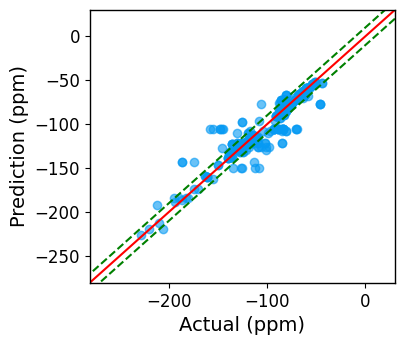

In [14]:
common.show_results_scatter(results, figure_title=None)

Prediction performance of the HOSE-based model on the validation dataset